# Introduction

Basically we are trying to find the best algorithm to classify the inhibitor types in our binary dataset from KinCoRe that we preprocessed. Here, we are trying out using Logistic Regression, Support Vector Machine, and Random Forest.

The workflow is as follows:
1. load packages, directory, and dataset
2. find the best combination of sampling and standardization/normalization methods that yields the best baseline model
3. run hyperparameter tuning for our model to get the highest metrics score
4. repeat with different algorithms

# Load dataset and directories

In [1]:
# general data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# file management packages
import csv, sys
import os
import copy
import pickle

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# modeling
from sklearn import preprocessing, model_selection, feature_selection, metrics
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# misc
from textwrap import wrap
import time


In [2]:
os.chdir('../data')

In [3]:
data_da = pd.read_csv('data_allo_desc-03.csv').drop(columns=['Unnamed: 0'])
data_da

,lig_smiles,LigandType,lig_at,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,O=C(O)[C@@H]1CCN1,Allosteric,509,9.919074,9.919074,0.250000,-0.730324,0.464852,28.857143,101.105,...,0,0,0,0,0,0,0,0,0,0
1,OCC1CC1,Allosteric,505,8.206019,8.206019,0.416667,0.416667,0.474736,23.400000,72.107,...,0,0,0,0,0,0,0,0,0,0
2,OCC1CC1,Allosteric,510,8.206019,8.206019,0.416667,0.416667,0.474736,23.400000,72.107,...,0,0,0,0,0,0,0,0,0,0
3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,Allosteric,61004,13.935889,13.935889,0.082839,-4.539718,0.393599,14.692308,532.570,...,0,0,0,0,0,0,0,0,0,0
4,CCCCCCCCCCCCCCCCCCO[P@@](=O)(O)OC1CC[N+](C)(C)CC1,Allosteric,500,12.109842,12.109842,0.145576,-3.899576,0.114812,18.838710,462.676,...,0,0,0,0,0,0,0,0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5196,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1390,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5197,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1392,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5198,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1389,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0
5199,O=C(O)c1ccc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)c...,non_allo,1001,14.647223,14.647223,0.109453,-1.022970,0.384505,12.264706,476.870,...,0,0,0,0,0,0,0,0,0,0


from here we can see that there are several columns that need to be dropped for the next step, such as `Unnamed: 0` and `lig_smiles`. The column `LigandType` needs to be separated as a target. The rest (209 columns) are features we'll use in the model.

# 0. preprocess data

workflow in this step is the following:
1. drop duplicate and null rows
2. drop feature that begins with `Unnamed` (since it was generated automatically when we did not reset the index in the last step before saving the data from the previous step into csv)
3. encode target using integer (0,1)
4. separate features and target
5. remove features which values don't have variation
6. remove feature that has low correlation with other features
7. split data into train-validation and test set
8. split data into train and validation set

In [4]:
def data_preprocessing(data,
                       target='LigandType', 
                       col_to_drop=['lig_smiles'],
                       test_size=0.2, 
                       val_size=0.2, 
                       random_state=0,
                       anova=True,
                       ):
    '''
    preprocess data from the previous workflow

    Args:
    ----------
      data: pd.DataFrame
        the input data to be preprocesed
      target: str
        target column for the model
      col_to_drop: list
        list of columns to drop
      test_size: float
        test size from the whole input data
      val_size: float
        validation set size from the whole input data
      anova: bool
        initial feature selection option using ANOVA

    Returns:
    ----------
      X_train, X_val, X_test, y_train, y_val, y_test: np.array
        the respective train, validation and test sets
      descnm: np.array
        feature names
    '''

    # drop duplicate rows
    data_ = data.drop_duplicates().dropna()

    # drop cols with 'unnamed'
    colidx_to_drop = [i for i in data.columns if 'Unnamed' in i]

    #encode target
    to_mask = {}

    for i,j in enumerate(data_[target].unique()):
        to_mask.update({j:i})

    data_ = data_.replace(to_mask)

    # separate x and y
    X = data_.loc[:, data_.columns.difference(col_to_drop+[target]+colidx_to_drop)]
    y = data_[target]

    # remove features that don't have variation
    X_out = X.loc[:,X.apply(pd.Series.nunique) != 1]
    mask = X_out.applymap(lambda x: isinstance(x, (int, float)))
    X_out2 = X_out.where(mask)
    X = X_out2.dropna(axis=1)

    if anova == True:
      # anova feature selection
      f_stat, p_val, = f_classif(X, y)

      # get index which probability is lower than p = 0.05
      idx = [i for i,j in enumerate(p_val) if j < 0.05]
      # select column with respective index
      X = X.iloc[:,idx]
    else:
      pass

    # split train-validation and test
    X_trainval, X_test, y_trainval, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state=random_state, stratify=y)
    # split train and validation
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_trainval, y_trainval, test_size = val_size/(1-val_size), random_state=random_state, stratify=y_trainval)

    descnm = np.array(X_train.columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    #return X_trainval, X_test, y_trainval, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test, descnm

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

In [6]:
print(len(y_train))
print(len(y_val))
print(len(y_test))
print(len(y_train)+len(y_val)+len(y_test))

3120
1040
1041
5201


In [ ]:
print(f'0 = {len([i for i in y_train if i == 0])}')
print(f'1 = {len([i for i in y_train if i == 1])}')

print(f'0 = {len([i for i in y_val if i == 0])}')
print(f'1 = {len([i for i in y_val if i == 1])}')

print(f'0 = {len([i for i in y_test if i == 0])}')
print(f'1 = {len([i for i in y_test if i == 1])}')

# 1. find combination of sampling and standardization methods for a baseline model

In [7]:
def model_(X_train, y_train, X_val, y_val,
                      algorithm = 'logreg',
                      multiclass = False,
                      kernel = 'rbf',
                      solver='liblinear',
                      max_iter=10000,
                      sampling = 'SMOTE',
                      scaling = True,
                      random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'logreg'
            - Support vector machine: 'svm'
            - Random forest: 'rf'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        dict
            A dictionary of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    if type(sampling) == str:
        sampling = [sampling]

    for i in sampling:
        if i == 'RandomUnderSampler':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'RandomOverSampler':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
    elif algorithm == 'SVC':
        model = SVC(kernel=kernel, random_state=random_state)
    else:
        model = RandomForestClassifier(random_state=random_state)
        scaling = False

    # scaling
    if scaling == False:
        train_scaled = {'none':X_train}
    else:
        X_train_MAS = preprocessing.MaxAbsScaler().fit_transform(X_train)
        X_train_MMS = preprocessing.MinMaxScaler().fit_transform(X_train)
        X_train_SS = preprocessing.StandardScaler().fit_transform(X_train)
        X_train_NORM = preprocessing.Normalizer().fit_transform(X_train)
        X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)

        train_scaled = {
            'none':X_train,
            'MaxAbsScaler':X_train_MAS,
            'MinMaxScaler':X_train_MMS,
            'StandardScaler':X_train_SS,
            'Normalizer':X_train_NORM,
            'Normalizer + MaxAbsScaler':X_train_NMAS,
            'Normalizer + MinMaxScaler':X_train_NMMS,
            'Normalizer + StandardScaler':X_train_NSS,
            'MaxAbsScaler + Normalizer':X_train_MASNORM,
            'MinMaxScaler + Normalizer':X_train_MMSNORM,
            'StandardScaler + Normalizer':X_train_SSNORM,
            }

    output_dict= {
        'sampling': [],
        'scaling': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_ba':[],
        'train_mcc':[],
        'val_accuracy':[],
        'val_f1':[],
        'val_ba':[],
        'val_mcc':[],
    }

    for sampl in sampling:
        for scaler, scaled in train_scaled.items():
            fit = model.fit(scaled, y_train)
            y_pred = fit.predict(scaled)
            y_val_pred = fit.predict(X_val)
            
            # calculate statistical metrics accuracy for training set
            train_accuracy = metrics.accuracy_score(y_train, y_pred)
            val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

            if multiclass == True:
                # calculate statistical metrics for training set
                train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

                # calculate statistical metrics for val set
                val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
            else:
                # calculate statistical metrics for training set
                train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                train_mcc = metrics.matthews_corrcoef(y_train, y_pred)

                # calculate statistical metrics for val set
                val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)


            output_dict['sampling'].append(sampl)
            output_dict['scaling'].append(scaler)
            # train metrics
            output_dict['train_accuracy'].append(train_accuracy)
            output_dict['train_f1'].append(train_f1)
            output_dict['train_ba'].append(train_ba)
            output_dict['train_mcc'].append(train_mcc)
            # val metrics
            output_dict['val_accuracy'].append(val_accuracy)
            output_dict['val_f1'].append(val_f1)
            output_dict['val_ba'].append(val_ba)
            output_dict['val_mcc'].append(val_mcc)
    return output_dict

In [18]:
def find_model(X_train, y_train, X_val, y_val,
                algorithm = 'logreg',
                multiclass = False,
                kernel = 'rbf',
                solver='liblinear',
                max_iter=10000,
                scaling = True,
                random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        algorithm: str
            The algorithm to use. Available are:
            - Logistic regression: 'LogisticRegression'
            - Support vector machine: 'SVC'
            - Random forest: 'RandomForestClassification'
        multiclass: bool
            Determining whether the classification is binary or multiclass.
            if `True` then the average metrics is computed as weighted
            if `False` then the average metrics is computed as binary
        kernel: str
            only applies in support vector machine. 
            The kernel you wish to run.
        solver: str
            only applies in logistic regression. 
            The solver you wish to run. Default is 'liblinear'.
        #sampling: str
        #    sampling method you wish to use. Available are:
        #    - smote
        #    - random_over
        #    - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        df_find_model
            A DataFrame of the scores between different sampling and scaling methods 
            across metrics of the training and validation data
    '''

    def model_(X_train, y_train, X_val, y_val,
                      algorithm = algorithm,
                      multiclass = multiclass,
                      kernel = kernel,
                      solver = solver,
                      sampling = 'SMOTE',
                      max_iter=max_iter,
                      scaling = scaling,
                      random_state=random_state):
        '''
        Find the best combination of sampling and
        standardization methods as a baseline model.

        Args:
        ----------
            X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
                Training and validation data and its targts
            algorithm: str
                The algorithm to use. Available are:
                - Logistic regression: 'logreg'
                - Support vector machine: 'svm'
                - Random forest: 'rf'
            multiclass: bool
                Determining whether the classification is binary or multiclass.
                if `True` then the average metrics is computed as weighted
                if `False` then the average metrics is computed as binary
            kernel: str
                only applies in support vector machine. 
                The kernel you wish to run.
            solver: str
                only applies in logistic regression. 
                The solver you wish to run. Default is 'liblinear'.
            sampling: str
                sampling method you wish to use. Available are:
                - smote
                - random_over
                - random_under
            scaling: bool
                scaling (standardization/normalization) of the data.

        Returns:
        ----------
            dict
                A dictionary of the scores between different sampling and scaling methods 
                across metrics of the training and validation data
        '''

        if type(sampling) == str:
            sampling = [sampling]

        for i in sampling:
            if i == 'RandomUnderSampler':
                X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'RandomOverSampler':
                X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
            elif i == 'SMOTE':
                X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
            else:
                pass
        
        if algorithm == 'LogisticRegression':
            model = LogisticRegression(solver=solver, random_state=random_state, max_iter=max_iter)
        elif algorithm == 'SVC':
            model = SVC(kernel=kernel, random_state=random_state)
        else:
            model = RandomForestClassifier(random_state=random_state)
            scaling = False

        # scaling
        if scaling == False:
            train_scaled = {'none':X_train}
            val_scaled = {'none':X_val}
        else:
            scaler = preprocessing.MaxAbsScaler()
            X_train_MAS = scaler.fit_transform(X_train)
            X_val_MAS = scaler.transform(X_val)

            scaler = preprocessing.MinMaxScaler()
            X_train_MMS = scaler.fit_transform(X_train)
            X_val_MMS = scaler.transform(X_val)

            scaler = preprocessing.StandardScaler()
            X_train_SS = scaler.fit_transform(X_train)
            X_val_SS = scaler.transform(X_val)

            scaler = preprocessing.Normalizer()
            X_train_NORM = scaler.fit_transform(X_train)
            X_val_NORM = scaler.transform(X_val)

            scaler = preprocessing.MaxAbsScaler()
            X_train_NMAS = scaler.fit_transform(X_train_NORM)
            X_val_NMAS = scaler.transform(X_val_NORM)

            scaler = preprocessing.MinMaxScaler()
            X_train_NMMS = scaler.fit_transform(X_train_NORM)
            X_val_NMMS = scaler.transform(X_val_NORM)

            scaler = preprocessing.StandardScaler()
            X_train_NSS = scaler.fit_transform(X_train_NORM)
            X_val_NSS = scaler.transform(X_val_NORM)

            scaler = preprocessing.Normalizer()
            X_train_MASNORM = scaler.fit_transform(X_train_MAS)
            X_val_MASNORM = scaler.transform(X_val_MAS)

            scaler = preprocessing.Normalizer()
            X_train_MMSNORM = scaler.fit_transform(X_train_MMS)
            X_val_MMSNORM = scaler.transform(X_val_MMS)

            scaler = preprocessing.Normalizer()
            X_train_SSNORM = scaler.fit_transform(X_train_SS)
            X_val_SSNORM = scaler.transform(X_val_SS)
            

            train_scaled = {
                'none':X_train,
                'MaxAbsScaler':X_train_MAS,
                'MinMaxScaler':X_train_MMS,
                'StandardScaler':X_train_SS,
                'Normalizer':X_train_NORM,
                'Normalizer + MaxAbsScaler':X_train_NMAS,
                'Normalizer + MinMaxScaler':X_train_NMMS,
                'Normalizer + StandardScaler':X_train_NSS,
                'MaxAbsScaler + Normalizer':X_train_MASNORM,
                'MinMaxScaler + Normalizer':X_train_MMSNORM,
                'StandardScaler + Normalizer':X_train_SSNORM,
                }
            
            val_scaled = {
                'none':X_val,
                'MaxAbsScaler':X_val_MAS,
                'MinMaxScaler':X_val_MMS,
                'StandardScaler':X_val_SS,
                'Normalizer':X_val_NORM,
                'Normalizer + MaxAbsScaler':X_val_NMAS,
                'Normalizer + MinMaxScaler':X_val_NMMS,
                'Normalizer + StandardScaler':X_val_NSS,
                'MaxAbsScaler + Normalizer':X_val_MASNORM,
                'MinMaxScaler + Normalizer':X_val_MMSNORM,
                'StandardScaler + Normalizer':X_val_SSNORM,
                }

        output_dict= {
            'sampling': [],
            'scaling': [],
            'train_accuracy': [],
            'train_f1': [],
            'train_ba':[],
            'train_mcc':[],
            'train_cf': [],
            'val_accuracy':[],
            'val_f1':[],
            'val_ba':[],
            'val_mcc':[],
            'val_cf': [],
        }

        for sampl in sampling:
            for scaler, scaled in train_scaled.items():
                for v_scaled in val_scaled.values():
                    fit = model.fit(scaled, y_train)
                    y_pred = fit.predict(scaled)
                    y_val_pred = fit.predict(v_scaled)


                    # calculate statistical metrics accuracy for training set
                    train_accuracy = metrics.accuracy_score(y_train, y_pred)
                    val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

                    if multiclass == True:
                        # calculate statistical metrics for training set
                        train_f1 = metrics.f1_score(y_train, y_pred, average = 'weighted')
                        train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                        train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                        train_cf = metrics.confusion_matrix(y_train, y_pred)

                        # calculate statistical metrics for val set
                        val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'weighted')
                        val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                        val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                        val_cf = metrics.confusion_matrix(y_val, y_val_pred)
                    else:
                        # calculate statistical metrics for training set
                        train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
                        train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
                        train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
                        train_cf = metrics.confusion_matrix(y_train, y_pred)

                        # calculate statistical metrics for val set
                        val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
                        val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
                        val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
                        val_cf = metrics.confusion_matrix(y_val, y_val_pred)


                    output_dict['sampling'].append(sampl)
                    output_dict['scaling'].append(scaler)
                    # train metrics
                    output_dict['train_accuracy'].append(train_accuracy)
                    output_dict['train_f1'].append(train_f1)
                    output_dict['train_ba'].append(train_ba)
                    output_dict['train_mcc'].append(train_mcc)
                    output_dict['train_cf'].append(train_cf)
                    # val metrics
                    output_dict['val_accuracy'].append(val_accuracy)
                    output_dict['val_f1'].append(val_f1)
                    output_dict['val_ba'].append(val_ba)
                    output_dict['val_mcc'].append(val_mcc)
                    output_dict['val_cf'].append(val_cf)
        return output_dict

    
    model_smote = model_(X_train, y_train, X_val, y_val, sampling = 'SMOTE', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_under = model_(X_train, y_train, X_val, y_val, sampling = 'RandomUnderSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_over = model_(X_train, y_train, X_val, y_val, sampling = 'RandomOverSampler', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)
    model_nosampling = model_(X_train, y_train, X_val, y_val, sampling = 'no_sampling', kernel=kernel, algorithm=algorithm, scaling=scaling, solver=solver, max_iter=max_iter)

    df_model = []
    for i in [model_smote, model_under, model_over, model_nosampling]:
        df = pd.DataFrame.from_dict(i)
        df_model.append(df)

    df_find_model = pd.concat(df_model, ignore_index=True)
    df_find_model = df_find_model.sort_values(by=['val_ba', 'val_mcc', 'train_ba', 'train_mcc'], ascending=False).round(3)
    #df_find_model.to_csv('linreg_allo_rdkit_model_baseline.csv')

    return df_find_model


get new standardized and sampled data

In [9]:
def sampled_scaled(X_train, y_train, 
            sampling = 'SMOTE',
            scaling = True,
            random_state=0):
    '''
    Find the best combination of sampling and
    standardization methods as a baseline model.

    Args:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training and validation data and its targts
        sampling: str
            sampling method you wish to use. Available are:
            - smote
            - random_over
            - random_under
        scaling: bool
            scaling (standardization/normalization) of the data.

    Returns:
    ----------
        X_train, y_train, X_val, y_val: np.array or pd.DataFrame or pd.Series
            Training data and its targets after sampled and scaled
    '''

    if type(sampling) == str:
        sampling = [sampling]
    if type(scaling) == str:
        scaling = [scaling]

    for i in sampling:
        if i == 'random_under':
            X_train, y_train  = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'random_over':
            X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
        elif i == 'SMOTE':
            X_train, y_train = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        else:
            pass

    # scaling
    for j in scaling:
        if j == 'MaxAbsScaler':
            X_train = preprocessing.MaxAbsScaler().fit_transform(X_train)
        elif j == 'MinMaxScaler':
            X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
        elif j == 'StandardScaler':
            X_train = preprocessing.StandardScaler().fit_transform(X_train)
        elif j == 'Normalizer':
            X_train = preprocessing.Normalizer().fit_transform(X_train)
        #elif j == 'MaxAbsScalerN':
        #    X_train_NMAS = preprocessing.MaxAbsScaler().fit_transform(X_train_NORM)
        #elif j == 'MinMaxScalerN':
        #    X_train_NMMS = preprocessing.MinMaxScaler().fit_transform(X_train_NORM)
        #elif j == 'StandardScalerN':
        #    X_train_NSS = preprocessing.StandardScaler().fit_transform(X_train_NORM)
        #elif j == 'NMaxAbsScaler':
        #    X_train_MASNORM = preprocessing.Normalizer().fit_transform(X_train_MAS)
        #elif j == 'NMinMaxScaler':
        #    X_train_MMSNORM = preprocessing.Normalizer().fit_transform(X_train_MMS)
        #elif j == 'NStandardScaler':
        #    X_train_SSNORM = preprocessing.Normalizer().fit_transform(X_train_SS)
        else:
            pass

    return X_train, y_train



# logistic regression

#### lbfgs

In [61]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

start_time = time.time()
model_lbfgs = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='lbfgs'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_lbfgs = end_time-start_time
print(f"Operation took {duration_lbfgs} seconds.")

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
model_lbfgs

In [ ]:
model_lbfgs.to_csv('da_lr_lbfgs.csv')

In [ ]:
model_lbfgs_melted = pd.melt(model_lbfgs, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_lbfgs_melted = model_lbfgs_melted.drop(model_lbfgs_melted[model_lbfgs_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_lbfgs_melted['set'] = np.where(model_lbfgs_melted['metrics'].str.startswith('train'), 'train', 'val')
model_lbfgs_melted['met'] = np.where(model_lbfgs_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_lbfgs_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_lbfgs_melted['sampling'] = np.where(model_lbfgs_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_lbfgs_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_lbfgs_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_lbfgs_melted = model_lbfgs_melted.drop(columns=['metrics'])
model_lbfgs_melted


In [ ]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='train'].value.mean()

In [ ]:
model_lbfgs_melted[model_lbfgs_melted['met']=='ba'][model_lbfgs_melted['set']=='val'].value.mean()

In [ ]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, lbfgs solver')
plt.show()


In [ ]:
sns.violinplot(data=model_lbfgs_melted[model_lbfgs_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, lbfgs solver')
plt.show()


#### liblinear

In [50]:
start_time = time.time()
model_liblinear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='liblinear'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_liblinear = end_time-start_time
print(f"Operation took {duration_liblinear} seconds.")

Operation took 32.29834508895874 seconds.


In [10]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
model_liblinear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='liblinear'))
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
43,SMOTE,StandardScaler,0.903,0.903,0.903,0.806,"[[2549, 270], [276, 2543]]",0.898,0.941,0.863,0.579,"[[82, 18], [88, 852]]"
338,RandomOverSampler,MaxAbsScaler + Normalizer,0.860,0.865,0.860,0.722,"[[2314, 505], [285, 2534]]",0.875,0.927,0.855,0.535,"[[83, 17], [113, 827]]"
278,RandomOverSampler,StandardScaler,0.884,0.884,0.884,0.768,"[[2487, 332], [321, 2498]]",0.862,0.919,0.852,0.515,"[[84, 16], [128, 812]]"
36,SMOTE,StandardScaler,0.903,0.903,0.903,0.806,"[[2549, 270], [276, 2543]]",0.876,0.928,0.851,0.532,"[[82, 18], [111, 829]]"
382,no_sampling,MaxAbsScaler,0.944,0.970,0.760,0.635,"[[160, 141], [34, 2785]]",0.905,0.946,0.849,0.578,"[[78, 22], [77, 863]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
175,RandomUnderSampler,Normalizer,0.748,0.767,0.748,0.502,"[[200, 101], [51, 250]]",0.610,0.752,0.427,-0.092,"[[20, 80], [326, 614]]"
81,SMOTE,Normalizer + StandardScaler,0.862,0.871,0.862,0.731,"[[2235, 584], [194, 2625]]",0.659,0.791,0.418,-0.109,"[[12, 88], [267, 673]]"
468,no_sampling,MinMaxScaler + Normalizer,0.935,0.965,0.694,0.553,"[[119, 182], [21, 2798]]",0.659,0.791,0.418,-0.109,"[[12, 88], [267, 673]]"
323,RandomOverSampler,Normalizer + StandardScaler,0.851,0.861,0.851,0.710,"[[2191, 628], [212, 2607]]",0.658,0.791,0.413,-0.116,"[[11, 89], [267, 673]]"


In [11]:
model_liblinear.to_csv('da_lr_liblinear.csv')
model_liblinear

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
43,SMOTE,StandardScaler,0.903,0.903,0.903,0.806,"[[2549, 270], [276, 2543]]",0.898,0.941,0.863,0.579,"[[82, 18], [88, 852]]"
338,RandomOverSampler,MaxAbsScaler + Normalizer,0.860,0.865,0.860,0.722,"[[2314, 505], [285, 2534]]",0.875,0.927,0.855,0.535,"[[83, 17], [113, 827]]"
278,RandomOverSampler,StandardScaler,0.884,0.884,0.884,0.768,"[[2487, 332], [321, 2498]]",0.862,0.919,0.852,0.515,"[[84, 16], [128, 812]]"
36,SMOTE,StandardScaler,0.903,0.903,0.903,0.806,"[[2549, 270], [276, 2543]]",0.876,0.928,0.851,0.532,"[[82, 18], [111, 829]]"
382,no_sampling,MaxAbsScaler,0.944,0.970,0.760,0.635,"[[160, 141], [34, 2785]]",0.905,0.946,0.849,0.578,"[[78, 22], [77, 863]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
175,RandomUnderSampler,Normalizer,0.748,0.767,0.748,0.502,"[[200, 101], [51, 250]]",0.610,0.752,0.427,-0.092,"[[20, 80], [326, 614]]"
81,SMOTE,Normalizer + StandardScaler,0.862,0.871,0.862,0.731,"[[2235, 584], [194, 2625]]",0.659,0.791,0.418,-0.109,"[[12, 88], [267, 673]]"
468,no_sampling,MinMaxScaler + Normalizer,0.935,0.965,0.694,0.553,"[[119, 182], [21, 2798]]",0.659,0.791,0.418,-0.109,"[[12, 88], [267, 673]]"
323,RandomOverSampler,Normalizer + StandardScaler,0.851,0.861,0.851,0.710,"[[2191, 628], [212, 2607]]",0.658,0.791,0.413,-0.116,"[[11, 89], [267, 673]]"


In [17]:
model_liblinear_melted = pd.melt(model_liblinear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_liblinear_melted = model_liblinear_melted.drop(model_liblinear_melted[model_liblinear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_liblinear_melted['set'] = np.where(model_liblinear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_liblinear_melted['met'] = np.where(model_liblinear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_liblinear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_liblinear_melted['sampling'] = np.where(model_liblinear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_liblinear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_liblinear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_liblinear_melted = model_liblinear_melted.drop(columns=['metrics'])
model_liblinear_melted


,sampling,scaling,value,set,met
484,SMOTE,StandardScaler,0.903,train,f1
485,Random Oversampler,MaxAbsScaler + Normalizer,0.865,train,f1
486,Random Oversampler,StandardScaler,0.884,train,f1
487,SMOTE,StandardScaler,0.903,train,f1
488,No Sampling,MaxAbsScaler,0.970,train,f1
...,...,...,...,...,...
3867,Random Undersampler,Normalizer,-0.092,val,mcc
3868,SMOTE,Normalizer + StandardScaler,-0.109,val,mcc
3869,No Sampling,MinMaxScaler + Normalizer,-0.109,val,mcc
3870,Random Oversampler,Normalizer + StandardScaler,-0.116,val,mcc


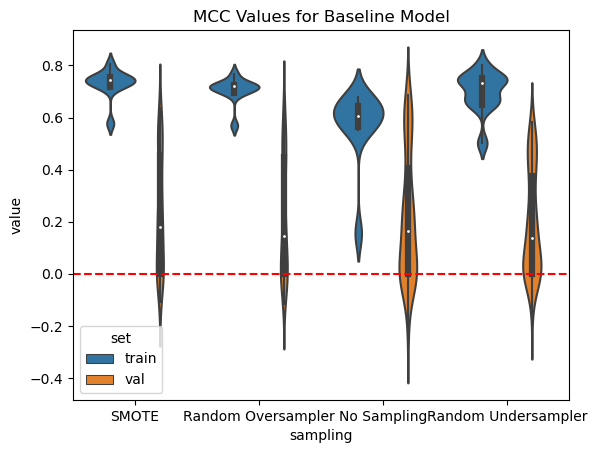

In [18]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model')
plt.show()


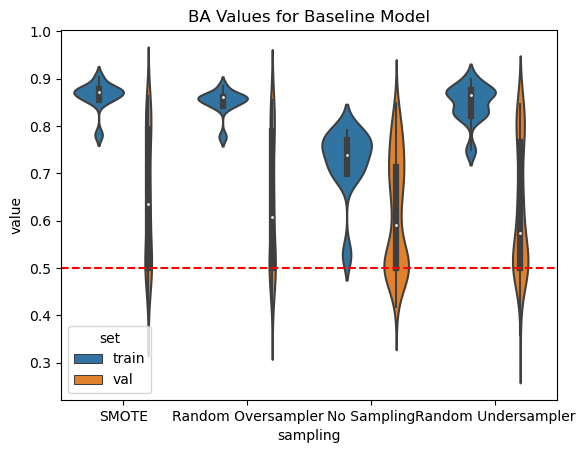

In [19]:
sns.violinplot(data=model_liblinear_melted[model_liblinear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model')
plt.show()


#### saga

In [ ]:
start_time = time.time()
model_saga = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='LogisticRegression', solver='saga'))#.to_csv('da_lr_saga.csv')
end_time = time.time()
duration_saga = end_time-start_time
print(f"Operation took {duration_saga} seconds.")
model_saga

In [ ]:
model_saga.to_csv('da_lr_saga.csv')

In [ ]:
model_saga_melted = pd.melt(model_saga, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_saga_melted = model_saga_melted.drop(model_saga_melted[model_saga_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_saga_melted['set'] = np.where(model_saga_melted['metrics'].str.startswith('train'), 'train', 'val')
model_saga_melted['met'] = np.where(model_saga_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_saga_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_saga_melted['sampling'] = np.where(model_saga_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_saga_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_saga_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_saga_melted = model_saga_melted.drop(columns=['metrics'])
model_saga_melted


In [ ]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.title('MCC Values for Baseline Model, saga solver')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [ ]:
sns.violinplot(data=model_saga_melted[model_saga_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Model, saga solver')
plt.show()


#### plot for all solvers

In [ ]:
model_saga_melted[model_saga_melted['met']=='mcc'].sort_values(['sampling', 'set'])

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'lbfgs, t = {round(duration_lbfgs, 2)} s')
ax[0, 1].set_title(f'liblinear, t = {round(duration_liblinear, 2)} s')
ax[0, 2].set_title(f'saga, t = {round(duration_saga, 2)} s')

for i, j in enumerate([model_lbfgs_melted, model_liblinear_melted, model_saga_melted]):
    sns.violinplot(data=j[j['met']=='mcc'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'].sort_values(['sampling', 'set']), x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

In [ ]:
model_liblinear

## feature importance

In [ ]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_train = preprocessing.Normalizer().fit_transform(X_train)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


In [ ]:
result = permutation_importance(fit, X_val, y_val, n_repeats=10, random_state=random_state)

feature_importance = pd.DataFrame({'Feature': descnm,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                             
                            yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')
plt.tight_layout
plt.show()

In [ ]:
feature_importance[feature_importance['Importance'] > 0].Feature.to_list()

### retrain

In [62]:
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
lr = LogisticRegression(max_iter=max_iter, random_state=random_state)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.903
balanced accuracy: 0.904
matthews corrcoeff: 0.807
cf:
[[2550  269]
 [ 275 2544]]

val scores 

f1: 0.928
balanced accuracy: 0.851
matthews corrcoeff: 0.532
cf:
[[ 82  18]
 [111 829]]


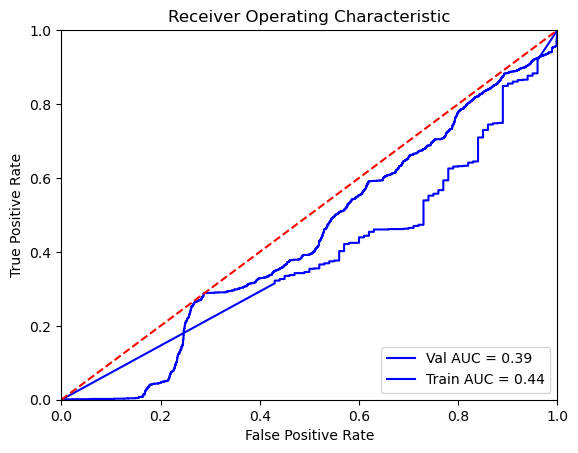

In [31]:
probs_t = fit.predict_proba(X_train)
preds_t = probs_t[:,1]
probs_v = fit.predict_proba(X_val)
preds_v = probs_v[:,1]

fpr_t, tpr_t, threshold = metrics.roc_curve(y_train, preds_t)
fpr_v, tpr_v, threshold = metrics.roc_curve(y_val, preds_v)
roc_auc_t = metrics.auc(fpr_t, tpr_t)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_v, tpr_v, 'b', label = 'Val AUC = %0.2f' % roc_auc_v)
plt.plot(fpr_t, tpr_t, 'b', label = 'Train AUC = %0.2f' % roc_auc_t)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## hyperparameter tuning using gridsearch

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

In [13]:
def grid_search(X_train, y_train,
                param_grid,
                algorithm = 'LogisticRegression',
                fold = 3,
                scoring='balanced_accuracy',
                random_state=0,
                ):
    
    if algorithm == 'LogisticRegression':
        model = LogisticRegression(random_state=random_state)
    elif algorithm == 'SVC':
        model = SVC(random_state=random_state)
    elif algorithm == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=random_state)
    else:
        pass

    cv_ = model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=fold,
        verbose=3,
        scoring=scoring,
        )
    cv_.fit(X_train, y_train)

    return cv_.cv_results_, cv_.best_params_


In [30]:
param_grid = {
    'solver': ['liblinear', 'saga', 'lbfgs'],# 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'class_weight':[None, 'balanced'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [10000],
    'random_state':[0]
}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='LogisticRegression',)

cv_params

Fitting 3 folds for each of 168 candidates, totalling 504 fits
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  21.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  26.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  28.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   0.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   0.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   0.8s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.001, class_weight=balanced, max

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l2, random_state=0, solver=saga;, score=0.795 total time=  40.3s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l2, random_state=0, solver=lbfgs;, score=0.851 total time=   0.1s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l2, random_state=0, solver=lbfgs;, score=0.806 total time=   0.1s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=l2, random_state=0, solver=lbfgs;, score=0.810 total time=   0.1s
[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=elasticnet, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, clas

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  31.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  31.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  28.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   1.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   2.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.001, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   4.7s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.1s
[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.1s
[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.500 total time=   0.2s
[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, penalty=l1, random

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  29.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  34.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  34.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   3.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   2.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   5.8s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.723 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.776 total time=   0.1s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.810 total time=   3.2s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.728 total time=   2.5s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.781 total time=   2.7s
[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=liblinear;, score=nan total time=   0.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  43.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  25.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  20.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   4.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   2.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.01, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   4.8s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.677 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.682 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.677 total time=   4.2s
[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.763 total time=   4.1s
[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.621 total time=   3.4s
[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, penalty=l1, random_state=0

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  25.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  25.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  27.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   1.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   2.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   1.6s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.827 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.846 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.844 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.832 total time=   5.1s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.840 total time=   4.2s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.847 total time=   3.0s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, pen

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  22.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  20.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  25.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   4.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   2.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   5.4s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.738 total time=   0.3s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.853 total time=   0.3s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.795 total time=   0.2s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.738 total time=  15.1s
[CV 2/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.855 total time=  16.8s
[CV 3/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.797 total time=  12.7s
[CV 1/3] END C=1, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=lbfgs;

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  19.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  20.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  25.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   1.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.714 total time=   5.0s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.815 total time=   2.3s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.761 total time=   6.4s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.719 total time=  26.7s
[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.831 total time=  28.4s
[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.784 total time=  30.0s
[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=l1,

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  24.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  23.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  22.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   1.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   0.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=10, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   2.5s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.739 total time=   7.4s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.787 total time=   5.9s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.719 total time=   8.8s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.768 total time=  27.8s
[CV 2/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.800 total time=  30.1s
[CV 3/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.730 total time=  41.7s
[CV 1/3] END C=100, class_weight=None, max_iter=10000, penalty=l1, random_state=0, 

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  17.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  18.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  20.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   0.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   0.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   1.2s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.734 total time=   9.7s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.785 total time=   7.2s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.733 total time=  14.7s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.732 total time=  36.2s
[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.831 total time=  26.3s
[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.781 total time=  35.8s
[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, pen

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  27.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  26.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  28.3s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   4.5s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   4.1s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=100, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   4.9s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.767 total time=  14.9s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.785 total time=   6.4s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.714 total time=  21.0s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.768 total time=  37.8s
[CV 2/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.800 total time=  37.8s
[CV 3/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.730 total time=  51.6s
[CV 1/3] END C=1000, class_weight=None, max_iter=10000, penalty=l1, random_s

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.768 total time=  36.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.800 total time=  31.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.730 total time=  36.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.765 total time=   1.2s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.770 total time=   1.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=None, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.722 total time=   5.7s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.762 total time=  17.8s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.785 total time=   7.4s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=liblinear;, score=0.714 total time=  20.8s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.732 total time=  35.5s
[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.831 total time=  25.2s
[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=l1, random_state=0, solver=saga;, score=0.779 total time=  36.5s
[CV 1/3] END C=1000, class_weight=balanced, max_iter=10

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.732 total time=  23.9s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.831 total time=  23.4s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=saga;, score=0.779 total time=  29.8s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.725 total time=   1.6s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.769 total time=   1.0s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=1000, class_weight=balanced, max_iter=10000, penalty=None, random_state=0, solver=lbfgs;, score=0.719 total time=   3.7s


/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 504.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'saga'}

In [33]:
da_lr_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
da_lr_cv_iter_1.to_csv('da_lr_cv_iter_1.csv', index=False)
da_lr_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
61,4.103121,0.876107,0.005883,0.002462,0.1,balanced,10000,l1,0,saga,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.831837,0.839551,0.846791,0.839393,0.006106,1
60,0.026956,0.001375,0.005607,0.001079,0.1,balanced,10000,l1,0,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.827060,0.846269,0.843596,0.838975,0.008495,2
41,0.638095,0.027446,0.014995,0.001471,0.01,balanced,10000,l2,0,lbfgs,"{'C': 0.01, 'class_weight': 'balanced', 'max_i...",0.836615,0.852659,0.826847,0.838707,0.010641,3
40,1.081204,0.209836,0.066823,0.086322,0.01,balanced,10000,l2,0,saga,"{'C': 0.01, 'class_weight': 'balanced', 'max_i...",0.836615,0.852659,0.826847,0.838707,0.010641,3
39,0.186355,0.065837,0.012411,0.001740,0.01,balanced,10000,l2,0,liblinear,"{'C': 0.01, 'class_weight': 'balanced', 'max_i...",0.833430,0.844672,0.837206,0.838436,0.004671,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.002707,0.000495,0.000000,0.000000,1000,balanced,10000,l1,0,lbfgs,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,99
162,0.004307,0.004160,0.000000,0.000000,1000,balanced,10000,elasticnet,0,liblinear,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,99
163,0.002508,0.000114,0.000000,0.000000,1000,balanced,10000,elasticnet,0,saga,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,99
164,0.001912,0.000291,0.000000,0.000000,1000,balanced,10000,elasticnet,0,lbfgs,"{'C': 1000, 'class_weight': 'balanced', 'max_i...",NaN,NaN,NaN,NaN,NaN,99


## test

In [14]:
solver='saga'
max_iter=10000
random_state=0
C=0.1
penalty='l1'
class_weight='balanced'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty, class_weight=class_weight)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'binary')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')


TRAIN scores 

f1: 0.771
balanced accuracy: 0.746
matthews corrcoeff: 0.505
cf:
[[1798 1021]
 [ 409 2410]]
-----------
VAL scores 

f1: 0.904
balanced accuracy: 0.762
matthews corrcoeff: 0.388
cf:
[[ 67  33]
 [138 802]]
-----------
TEST scores 

f1: 0.898
balanced accuracy: 0.725
matthews corrcoeff: 0.335
cf:
[[ 60  40]
 [142 799]]



# svm

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

## linear

In [ ]:
start_time = time.time()
model_linear = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='linear'))
model_linear.to_csv('da_svm_linear.csv')
end_time = time.time()
duration_linear = end_time-start_time
print(f"Operation took {duration_linear} seconds.")

In [ ]:
len(model_linear)

In [ ]:
model_linear

In [ ]:
model_linear_melted = pd.melt(model_linear, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_linear_melted = model_linear_melted.drop(model_linear_melted[model_linear_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_linear_melted['set'] = np.where(model_linear_melted['metrics'].str.startswith('train'), 'train', 'val')
model_linear_melted['met'] = np.where(model_linear_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_linear_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_linear_melted['sampling'] = np.where(model_linear_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_linear_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_linear_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_linear_melted = model_linear_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_linear_melted


In [ ]:
model_linear_melted[model_linear_melted['met']=='mcc']

In [ ]:
sns.violinplot(data=model_linear_melted[model_linear_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


In [ ]:
sns.violinplot(data=model_linear_melted[model_linear_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


## poly

In [ ]:
start_time = time.time()
model_poly = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='poly'))
model_poly.to_csv('da_svm_poly.csv')
end_time = time.time()
duration_poly = end_time-start_time
print(f"Operation took {duration_poly} seconds.")

In [ ]:
model_poly_melted = pd.melt(model_poly, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_poly_melted = model_poly_melted.drop(model_poly_melted[model_poly_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_poly_melted['set'] = np.where(model_poly_melted['metrics'].str.startswith('train'), 'train', 'val')
model_poly_melted['met'] = np.where(model_poly_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_poly_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_poly_melted['sampling'] = np.where(model_poly_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_poly_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_poly_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_poly_melted = model_poly_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_poly_melted


In [ ]:
model_poly_melted.sampling.unique()

In [ ]:
model_poly_melted[model_poly_melted['sampling']=='Random Oversampler']

In [ ]:
sns.boxplot(data=model_poly_melted[model_poly_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
sns.swarmplot(data=model_poly_melted[model_poly_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set', alpha=0.5,)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Model, linear kernel')
plt.show()


## rbf

In [34]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

In [35]:
start_time = time.time()
model_rbf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='rbf'))
model_rbf.to_csv('da_svm_rbf.csv')
end_time = time.time()
duration_rbf = end_time-start_time
print(f"Operation took {duration_rbf} seconds.")
model_rbf

Operation took 3080.3492970466614 seconds.


,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
362,RandomOverSampler,StandardScaler + Normalizer,0.972,0.971,0.972,0.944,"[[2774, 45], [115, 2704]]",0.937,0.964,0.898,0.696,"[[85, 15], [51, 889]]"
278,RandomOverSampler,StandardScaler,0.966,0.965,0.966,0.932,"[[2760, 59], [133, 2686]]",0.926,0.958,0.892,0.663,"[[85, 15], [62, 878]]"
120,SMOTE,StandardScaler + Normalizer,0.975,0.974,0.975,0.949,"[[2767, 52], [91, 2728]]",0.941,0.967,0.892,0.705,"[[83, 17], [44, 896]]"
254,RandomOverSampler,MaxAbsScaler,0.938,0.938,0.938,0.877,"[[2656, 163], [184, 2635]]",0.902,0.944,0.883,0.605,"[[86, 14], [88, 852]]"
255,RandomOverSampler,MaxAbsScaler,0.938,0.938,0.938,0.877,"[[2656, 163], [184, 2635]]",0.917,0.953,0.883,0.635,"[[84, 16], [70, 870]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
391,no_sampling,MinMaxScaler,0.942,0.969,0.729,0.613,"[[140, 161], [20, 2799]]",0.660,0.792,0.427,-0.096,"[[14, 86], [268, 672]]"
294,RandomOverSampler,Normalizer,0.806,0.828,0.806,0.634,"[[1913, 906], [186, 2633]]",0.194,0.238,0.425,-0.123,"[[71, 29], [809, 131]]"
21,SMOTE,MaxAbsScaler,0.951,0.951,0.951,0.902,"[[2676, 143], [132, 2687]]",0.603,0.746,0.423,-0.096,"[[20, 80], [333, 607]]"
174,RandomUnderSampler,Normalizer,0.774,0.805,0.774,0.578,"[[185, 116], [20, 281]]",0.259,0.354,0.402,-0.134,"[[58, 42], [729, 211]]"


In [ ]:
model_rbf_melted = pd.melt(model_rbf, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_rbf_melted = model_rbf_melted.drop(model_rbf_melted[model_rbf_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_rbf_melted['set'] = np.where(model_rbf_melted['metrics'].str.startswith('train'), 'train', 'val')
model_rbf_melted['met'] = np.where(model_rbf_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_rbf_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_rbf_melted['sampling'] = np.where(model_rbf_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_rbf_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_rbf_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_rbf_melted = model_rbf_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_rbf_melted


## sigmoid

In [ ]:
start_time = time.time()
model_sigmoid = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='SVC', kernel='sigmoid'))
model_sigmoid.to_csv('da_svm_sigmoid.csv')
end_time = time.time()
duration_sigmoid = end_time-start_time
print(f"Operation took {duration_sigmoid} seconds.")

In [ ]:
model_sigmoid_melted = pd.melt(model_sigmoid, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_sigmoid_melted = model_sigmoid_melted.drop(model_sigmoid_melted[model_sigmoid_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_sigmoid_melted['set'] = np.where(model_sigmoid_melted['metrics'].str.startswith('train'), 'train', 'val')
model_sigmoid_melted['met'] = np.where(model_sigmoid_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_sigmoid_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_sigmoid_melted['sampling'] = np.where(model_sigmoid_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_sigmoid_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_sigmoid_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_sigmoid_melted = model_sigmoid_melted.drop(columns=['metrics']).sort_values(['sampling', 'set'])
model_sigmoid_melted


## plot for all kernels

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 6), sharex=True, sharey=True)

ax[0, 0].set_title(f'linear, t = {round(duration_linear, 2)} s')
ax[0, 1].set_title(f'poly, t = {round(duration_poly, 2)} s')
ax[0, 2].set_title(f'rbf, t = {round(duration_rbf, 2)} s')
ax[0, 3].set_title(f'sigmoid, t = {round(duration_sigmoid, 2)} s')

for i, j in enumerate([model_linear_melted, model_poly_melted, model_rbf_melted, model_sigmoid_melted]):
    sns.violinplot(data=j[j['met']=='mcc'], x='sampling', y='value', hue='set', ax=ax[0, i])
    sns.violinplot(data=j[j['met']=='ba'], x='sampling', y='value', hue='set', ax=ax[1, i])
    ax[0, i].axhline(y=0, color='r', linestyle='--')
    ax[1, i].axhline(y=0.5, color='r', linestyle='--')
    ax[1, i].set_xticklabels(ax[1, i].get_xticklabels(), rotation=90, ha='center')
    ax[0, i].set_xlabel('')
    ax[1, i].set_xlabel('')
    ax[0, i].set_ylabel('')
    ax[1, i].set_ylabel('')
    ax[0, 0].set_ylabel('Matthews Correlation\nCoefficient')
    ax[1, 0].set_ylabel('Balanced Accuracy')
plt.setp(ax,
         yticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4],
         xticklabels=['No\nSampling',  'Random\nOversampling', 'Random\nUndersampling', 'SMOTE'],
)
plt.show()

## feature importance

## hyperparameter tuning

In [59]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001,],
    'random_state':[0],
    'class_weight': ['balanced', None],
    'probability': [True],

}
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='SVC',)

cv_params

Fitting 3 folds for each of 224 candidates, totalling 672 fits
[CV 1/3] END C=0.001, class_weight=balanced, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.813 total time=   1.1s
[CV 2/3] END C=0.001, class_weight=balanced, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.835 total time=   1.3s
[CV 3/3] END C=0.001, class_weight=balanced, gamma=1, kernel=linear, probability=True, random_state=0;, score=0.824 total time=   1.5s
[CV 1/3] END C=0.001, class_weight=balanced, gamma=1, kernel=poly, probability=True, random_state=0;, score=0.774 total time=   1.6s
[CV 2/3] END C=0.001, class_weight=balanced, gamma=1, kernel=poly, probability=True, random_state=0;, score=0.808 total time=   1.3s
[CV 3/3] END C=0.001, class_weight=balanced, gamma=1, kernel=poly, probability=True, random_state=0;, score=0.810 total time=   1.5s
[CV 1/3] END C=0.001, class_weight=balanced, gamma=1, kernel=rbf, probability=True, random_state=0;, score=0.500 total time=   3.4s
[

{'C': 10,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'sigmoid',
 'probability': True,
 'random_state': 0}

In [60]:
da_svm_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
da_svm_cv_iter_1.to_csv('da_svm_cv_iter_1.csv', index=False)
da_svm_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,param_probability,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
143,0.337566,0.014636,0.029467,0.008131,10,balanced,0.001,sigmoid,True,0,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.846169,0.860975,0.823652,0.843599,0.015345,1
44,1.724689,0.526533,0.062039,0.030871,0.01,balanced,0.001,linear,True,0,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.847761,0.860975,0.813293,0.840676,0.020101,2
40,0.581183,0.114444,0.047465,0.021854,0.01,balanced,0.01,linear,True,0,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.847761,0.860975,0.813293,0.840676,0.020101,2
36,0.664606,0.053326,0.034762,0.014114,0.01,balanced,0.1,linear,True,0,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.847761,0.860975,0.813293,0.840676,0.020101,2
32,0.614988,0.223978,0.030810,0.006521,0.01,balanced,1,linear,True,0,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",0.847761,0.860975,0.813293,0.840676,0.020101,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,1.741245,0.671529,0.283178,0.017473,0.01,None,1,rbf,True,0,"{'C': 0.01, 'class_weight': None, 'gamma': 1, ...",0.500000,0.500000,0.500000,0.500000,0.000000,184
51,0.333903,0.040976,0.020721,0.005486,0.01,None,1,sigmoid,True,0,"{'C': 0.01, 'class_weight': None, 'gamma': 1, ...",0.500000,0.500000,0.500000,0.500000,0.000000,184
15,0.813089,0.095525,0.061094,0.005496,0.001,balanced,0.001,sigmoid,True,0,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.500000,0.500000,0.500000,0.500000,0.000000,184
14,2.407443,0.829883,0.283469,0.157067,0.001,balanced,0.001,rbf,True,0,"{'C': 0.001, 'class_weight': 'balanced', 'gamm...",0.500000,0.500000,0.500000,0.500000,0.000000,184


In [61]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.0001, 0.00001, 0.000001],
    'random_state':[0],
    'class_weight': ['balanced', None],
    'probability': [True],

}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='SVC',)

cv_params

Fitting 3 folds for each of 224 candidates, totalling 672 fits
[CV 1/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.500 total time=   0.7s
[CV 2/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.500 total time=   0.8s
[CV 3/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=linear, probability=True, random_state=0;, score=0.500 total time=   0.9s
[CV 1/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=poly, probability=True, random_state=0;, score=0.500 total time=   0.8s
[CV 2/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=poly, probability=True, random_state=0;, score=0.500 total time=   0.7s
[CV 3/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=poly, probability=True, random_state=0;, score=0.500 total time=   0.7s
[CV 1/3] END C=0.001, class_weight=balanced, gamma=0.001, kernel=rbf, probability=True, random_state=0;, scor

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'probability': True,
 'random_state': 0}

In [62]:
da_svm_cv_iter_2 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
da_svm_cv_iter_2.to_csv('da_svm_cv_iter_2.csv', index=False)
da_svm_cv_iter_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,param_probability,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
194,0.266674,0.015576,0.038516,0.000992,1000,balanced,0.001,rbf,True,0,"{'C': 1000, 'class_weight': 'balanced', 'gamma...",0.841392,0.864170,0.833237,0.846266,0.013091,1
104,0.208712,0.007056,0.052277,0.010900,1,balanced,0.00001,linear,True,0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.847761,0.854257,0.824475,0.842164,0.012786,2
96,0.229137,0.033264,0.021618,0.008672,1,balanced,0.001,linear,True,0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.847761,0.854257,0.824475,0.842164,0.012786,2
100,0.244782,0.034098,0.021423,0.005596,1,balanced,0.0001,linear,True,0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.847761,0.854257,0.824475,0.842164,0.012786,2
108,0.256694,0.039484,0.027177,0.014622,1,balanced,0.000001,linear,True,0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.847761,0.854257,0.824475,0.842164,0.012786,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.087671,0.015062,0.014242,0.004290,0.1,None,0.001,poly,True,0,"{'C': 0.1, 'class_weight': None, 'gamma': 0.00...",0.500000,0.500000,0.500000,0.500000,0.000000,61
82,0.118529,0.007583,0.020895,0.001772,0.1,None,0.001,rbf,True,0,"{'C': 0.1, 'class_weight': None, 'gamma': 0.00...",0.500000,0.500000,0.500000,0.500000,0.000000,61
83,0.129689,0.013638,0.012949,0.002738,0.1,None,0.001,sigmoid,True,0,"{'C': 0.1, 'class_weight': None, 'gamma': 0.00...",0.500000,0.500000,0.500000,0.500000,0.000000,61
84,0.121454,0.037790,0.010404,0.002137,0.1,None,0.0001,linear,True,0,"{'C': 0.1, 'class_weight': None, 'gamma': 0.00...",0.500000,0.500000,0.500000,0.500000,0.000000,61


In [39]:
da_svm_cv_iter_1.params[0]

{'class_weight': 'balanced', 'gamma': 1, 'kernel': 'linear', 'random_state': 0}

## test

In [58]:
kernel='linear'
max_iter=10000
random_state=0
gamma=1
class_weight='balanced'

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
scaler = preprocessing.Normalizer()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# create final model in linreg
svm = SVC(probability=True, kernel=kernel,max_iter=max_iter, random_state=random_state, gamma=gamma, class_weight=class_weight)
fit = svm.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'binary')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'TRAIN scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('-----------')
print(f'VAL scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('-----------')
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')


TRAIN scores 

f1: 0.874
balanced accuracy: 0.871
matthews corrcoeff: 0.743
cf:
[[2400  419]
 [ 306 2513]]
-----------
VAL scores 

f1: 0.928
balanced accuracy: 0.851
matthews corrcoeff: 0.532
cf:
[[ 82  18]
 [111 829]]
-----------
TEST scores 

f1: 0.929
balanced accuracy: 0.834
matthews corrcoeff: 0.516
cf:
[[ 78  22]
 [106 835]]



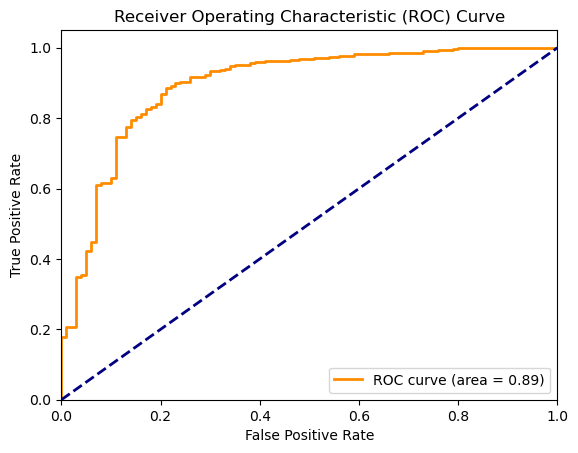

In [50]:
# Make predictions on the test set
y_pred_proba = fit.predict_proba(X_test)[:, 1] #lr

# Calculate ROC curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

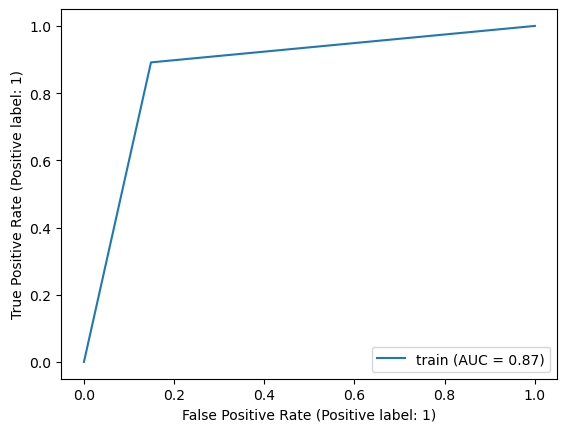

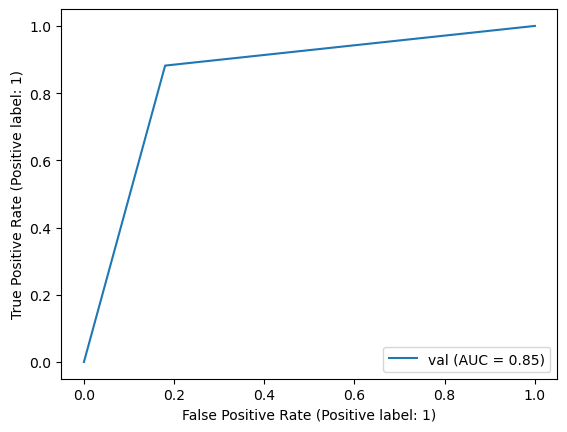

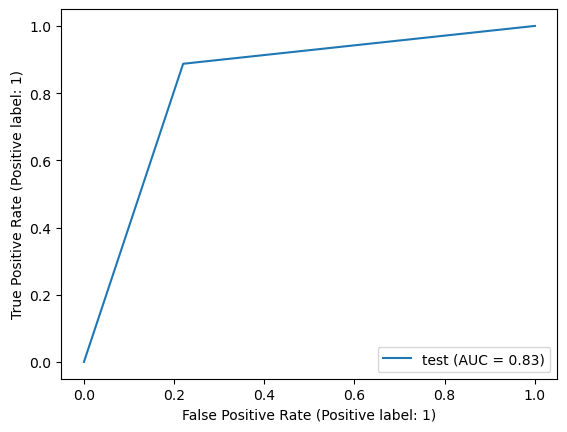

In [45]:
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [44]:
print(f'TEST scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')

TEST scores 

f1: 0.929
balanced accuracy: 0.834
matthews corrcoeff: 0.516
cf:
[[ 78  22]
 [106 835]]



# rf

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

In [19]:
start_time = time.time()
model_rf = pd.DataFrame(find_model(X_train, y_train, X_val, y_val, algorithm='RandomForestClassifier'))#.to_csv('da_lr_lbfgs.csv')
end_time = time.time()
duration_rf = end_time-start_time
print(f"Operation took {duration_rf} seconds.")

Operation took 26.06202006340027 seconds.


In [20]:
model_rf

,sampling,scaling,train_accuracy,train_f1,train_ba,train_mcc,train_cf,val_accuracy,val_f1,val_ba,val_mcc,val_cf
1,RandomUnderSampler,none,1.000,1.000,1.000,1.000,"[[301, 0], [0, 301]]",0.888,0.935,0.875,0.574,"[[86, 14], [103, 837]]"
0,SMOTE,none,0.999,0.999,0.999,0.999,"[[2816, 3], [1, 2818]]",0.950,0.972,0.852,0.710,"[[73, 27], [25, 915]]"
2,RandomOverSampler,none,0.999,0.999,0.999,0.999,"[[2819, 0], [4, 2815]]",0.947,0.971,0.832,0.686,"[[69, 31], [24, 916]]"
3,no_sampling,none,0.999,0.999,0.995,0.993,"[[298, 3], [1, 2818]]",0.950,0.973,0.825,0.696,"[[67, 33], [19, 921]]"


In [21]:
model_rf.to_csv('da_rf.csv')

In [ ]:
model_rf = pd.read_csv('da_rf.csv')

In [ ]:
model_rf_melted = pd.melt(model_rf, id_vars=['sampling', 'scaling'], value_vars=['train_accuracy', 'train_f1', 'train_ba', 'train_mcc', 'val_accuracy', 'val_f1', 'val_ba', 'val_mcc',], var_name='metrics', value_name='value')
model_rf_melted = model_rf_melted.drop(model_rf_melted[model_rf_melted['metrics'].isin(['train_accuracy', 'val_accuracy'])].index)
model_rf_melted['set'] = np.where(model_rf_melted['metrics'].str.startswith('train'), 'train', 'val')
model_rf_melted['met'] = np.where(model_rf_melted['metrics'].str.endswith('f1'), 'f1', 
                                     np.where(model_rf_melted['metrics'].str.endswith('ba'), 'ba', 'mcc'))
model_rf_melted['sampling'] = np.where(model_rf_melted['sampling'].str.startswith('RandomOver'), 'Random Oversampler', 
                                          np.where(model_rf_melted['sampling'].str.startswith('RandomUnder'), 'Random Undersampler', 
                                                   np.where(model_rf_melted['sampling'].str.startswith('SMOTE'), 'SMOTE', 'No Sampling'
                                          )))
model_rf_melted = model_rf_melted.drop(columns=['metrics'])
model_rf_melted


In [ ]:
sns.barplot(data=model_rf_melted[model_rf_melted['met']=='mcc'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('MCC Values for Baseline Random Forest Model')
plt.show()


In [ ]:
sns.barplot(data=model_rf_melted[model_rf_melted['met']=='ba'], 
               x='sampling', y='value', hue='set',)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('BA Values for Baseline Random Forest Model')
plt.show()


## plot

In [ ]:

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharex=True, sharey=True)
ax[0].set_title(f'Matthews Correlation Coefficient')
ax[1].set_title(f'Balanced Accuracy')

sns.barplot(data=model_rf_melted[model_rf_melted['met']=='mcc'], x='sampling', y='value', hue='set', ax=ax[0])
sns.barplot(data=model_rf_melted[model_rf_melted['met']=='ba'], x='sampling', y='value', hue='set', ax=ax[1])
ax[1].axhline(0.5, color='r', linestyle='--')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='center')

plt.show()

## baseline

In [22]:
solver='liblinear'
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

# create final model in RF
lr = RandomForestClassifier(random_state=random_state,)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')


train scores 

f1: 0.999
balanced accuracy: 0.999
matthews corrcoeff: 0.999
cf:
[[2816    3]
 [   1 2818]]

val scores 

f1: 0.972
balanced accuracy: 0.852
matthews corrcoeff: 0.710
cf:
[[ 73  27]
 [ 25 915]]


## hyperparameter tuning

In [24]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state':[0],
    'class_weight': ['balanced', 'balanced_subsample', None],

}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='RandomForestClassifier',)

cv_params

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.675 total time=   1.9s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.740 total time=   1.6s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=1, random_state=0;, score=0.756 total time=   1.7s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.742 total time=   1.9s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.868 total time=   2.0s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=5, random_state=0;, score=0.797 total time=   1.9s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': None,
 'min_samples_leaf': 10,
 'random_state': 0}

In [26]:
da_rf_cv_iter_1 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
da_rf_cv_iter_1.to_csv('da_rf_cv_iter_1.csv', index=False)
da_rf_cv_iter_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
44,5.818527,0.134564,0.032104,0.001340,balanced_subsample,entropy,None,10,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.877889,0.824523,0.814962,0.055696,1
53,5.877935,0.327041,0.043346,0.010744,balanced_subsample,log_loss,None,10,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.877889,0.824523,0.814962,0.055696,1
26,7.957222,0.969348,0.062438,0.042094,balanced,log_loss,None,10,0,"{'class_weight': 'balanced', 'criterion': 'log...",0.740880,0.874695,0.826121,0.813898,0.055309,3
17,13.277467,2.112826,0.193962,0.182547,balanced,entropy,None,10,0,"{'class_weight': 'balanced', 'criterion': 'ent...",0.740880,0.874695,0.826121,0.813898,0.055309,3
20,2.456483,0.672437,0.079780,0.048148,balanced,log_loss,sqrt,10,0,"{'class_weight': 'balanced', 'criterion': 'log...",0.732098,0.864781,0.841272,0.812717,0.057809,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.956588,0.002387,0.030127,0.005445,None,log_loss,sqrt,10,0,"{'class_weight': None, 'criterion': 'log_loss'...",0.643553,0.717393,0.724078,0.695008,0.036486,76
56,1.354509,0.136704,0.048654,0.010078,None,gini,sqrt,10,0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.643553,0.702687,0.722480,0.689574,0.033530,78
68,0.797531,0.085434,0.031417,0.004302,None,entropy,log2,10,0,"{'class_weight': None, 'criterion': 'entropy',...",0.643553,0.702687,0.710524,0.685588,0.029895,79
77,0.774161,0.049130,0.029400,0.001344,None,log_loss,log2,10,0,"{'class_weight': None, 'criterion': 'log_loss'...",0.643553,0.702687,0.710524,0.685588,0.029895,79


iter 2

In [27]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [10, 15, 20, 50, 100],
    'max_features': ['sqrt', 'log2', None],
    'random_state':[0],
    'class_weight': ['balanced', 'balanced_subsample', None],

}

random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)
X_train, y_train  = SMOTE(random_state=random_state).fit_resample(X_train, y_train)

cv_res, cv_params = grid_search(X_val, y_val, param_grid, 
                                algorithm='RandomForestClassifier',)

cv_params

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.742 total time=   0.5s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.858 total time=   0.4s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=10, random_state=0;, score=0.835 total time=   0.5s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.759 total time=   0.5s
[CV 2/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.833 total time=   0.5s
[CV 3/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=15, random_state=0;, score=0.830 total time=   0.4s
[CV 1/3] END class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_leaf=20, rando

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'random_state': 0}

In [28]:
da_rf_cv_iter_2 = pd.DataFrame(cv_res).sort_values(by='mean_test_score', ascending=False)
da_rf_cv_iter_2.to_csv('da_rf_cv_iter_2.csv', index=False)
da_rf_cv_iter_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
46,0.562465,0.095795,0.016620,0.003978,balanced_subsample,gini,sqrt,15,0,"{'class_weight': 'balanced_subsample', 'criter...",0.760809,0.863512,0.828493,0.817605,0.042630,1
85,4.906340,0.485423,0.033680,0.001260,balanced_subsample,log_loss,None,10,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.877889,0.824523,0.814962,0.055696,2
70,2.667149,0.237707,0.013256,0.000629,balanced_subsample,entropy,None,10,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.877889,0.824523,0.814962,0.055696,2
86,4.588633,0.344412,0.052771,0.026851,balanced_subsample,log_loss,None,15,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.868305,0.833285,0.814687,0.053027,4
71,2.266098,0.153231,0.011883,0.000198,balanced_subsample,entropy,None,15,0,"{'class_weight': 'balanced_subsample', 'criter...",0.742472,0.868305,0.833285,0.814687,0.053027,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2.008882,0.187799,0.030724,0.013057,None,gini,None,100,0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.500000,0.500000,0.500000,0.500000,0.000000,121
99,0.627348,0.057701,0.055155,0.025564,None,gini,log2,100,0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.500000,0.500000,0.500000,0.500000,0.000000,121
98,0.558840,0.016569,0.045478,0.009531,None,gini,log2,50,0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.500000,0.500000,0.500000,0.500000,0.000000,121
94,0.555111,0.006644,0.032573,0.005799,None,gini,sqrt,100,0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.500000,0.500000,0.500000,0.500000,0.000000,121


In [30]:
da_rf_cv_iter_2.params[46]

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'random_state': 0}

## test

In [33]:
class_weight = 'balanced_subsample'
criterion = 'gini'
max_features = 'sqrt'
min_samples_leaf=15
max_iter=10000
random_state=0

X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

X_train, y_train  = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

# create final model in RF
lr = RandomForestClassifier(random_state=random_state, class_weight=class_weight, criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
fit = lr.fit(X_train, y_train)
y_pred = fit.predict(X_train)
y_val_pred = fit.predict(X_val)
y_test_pred = fit.predict(X_test)

# calculate statistical metrics for training set
train_f1 = metrics.f1_score(y_train, y_pred, average = 'binary')
train_ba = metrics.balanced_accuracy_score(y_train, y_pred)
train_mcc = metrics.matthews_corrcoef(y_train, y_pred)
train_cf = metrics.confusion_matrix(y_train, y_pred)

# calculate statistical metrics for val set
val_f1 = metrics.f1_score(y_val, y_val_pred, average = 'binary')
val_ba = metrics.balanced_accuracy_score(y_val, y_val_pred)
val_mcc = metrics.matthews_corrcoef(y_val, y_val_pred)
val_cf = metrics.confusion_matrix(y_val, y_val_pred)

# calculate statistical metrics for testing set
test_f1 = metrics.f1_score(y_test, y_test_pred, average = 'binary')
test_ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
test_mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
test_cf = metrics.confusion_matrix(y_test, y_test_pred)

print(f'train scores \n')
print(f'f1: {train_f1:.3f}')
print(f'balanced accuracy: {train_ba:.3f}')
print(f'matthews corrcoeff: {train_mcc:.3f}')
print(f'cf:\n{train_cf}')
print('')
print(f'val scores \n')
print(f'f1: {val_f1:.3f}')
print(f'balanced accuracy: {val_ba:.3f}')
print(f'matthews corrcoeff: {val_mcc:.3f}')
print(f'cf:\n{val_cf}')
print('')
print(f'test scores \n')
print(f'f1: {test_f1:.3f}')
print(f'balanced accuracy: {test_ba:.3f}')
print(f'matthews corrcoeff: {test_mcc:.3f}')
print(f'cf:\n{test_cf}')
print('')


train scores 

f1: 0.969
balanced accuracy: 0.969
matthews corrcoeff: 0.938
cf:
[[2756   63]
 [ 113 2706]]

val scores 

f1: 0.962
balanced accuracy: 0.877
matthews corrcoeff: 0.666
cf:
[[ 81  19]
 [ 52 888]]

test scores 

f1: 0.960
balanced accuracy: 0.848
matthews corrcoeff: 0.632
cf:
[[ 75  25]
 [ 50 891]]



## test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, descnm = data_preprocessing(data_da)

rf = RandomForestClassifier(random_state=random_state, class_weight='balanced_subsample', criterion='entropy', max_features='log2', min_samples_leaf=10)
fit_train = rf.fit(X_train, y_train)
y_train_pred = fit_train.predict(X_train)

# Make predictions on the test set
y_pred_proba = fit_train.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# roc/auc curve

/opt/anaconda3/envs/kinase/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


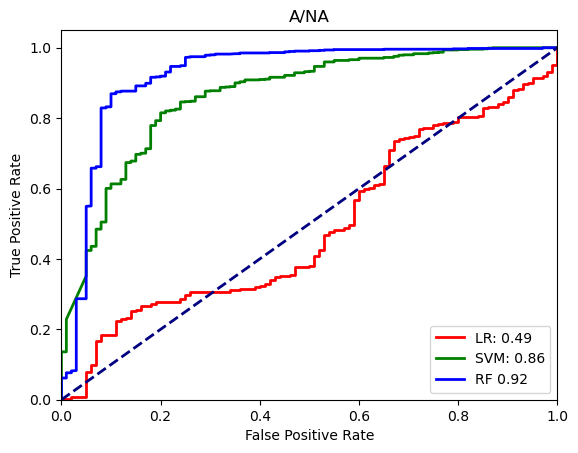

In [57]:
#LOGREG
solver='saga'
max_iter=10000
random_state=0
C=0.1
penalty='l1'
class_weight='balanced'

X_train_lr, X_val_lr, X_test_lr, y_train_lr, y_val_lr, y_test_lr, descnm = data_preprocessing(data_da)

X_train_lr, y_train_lr  = SMOTE(random_state=random_state).fit_resample(X_train_lr, y_train_lr)
scaler = preprocessing.Normalizer()
X_train_lr = scaler.fit_transform(X_train_lr)
X_val_lr = scaler.transform(X_val_lr)
X_test_lr = scaler.transform(X_test_lr)

# create final model in linreg
lr = LogisticRegression(solver=solver,max_iter=max_iter, random_state=random_state, C=C, penalty=penalty, class_weight=class_weight)
lr.fit(X_train, y_train)

#SVM
kernel='linear'
max_iter=10000
random_state=0
gamma=1
class_weight='balanced'

X_train_svm, X_val_svm, X_test_svm, y_train_svm, y_val_svm, y_test_svm, descnm = data_preprocessing(data_da)

X_train_svm, y_train_svm  = RandomOverSampler(random_state=random_state).fit_resample(X_train_svm, y_train_svm)
scaler = preprocessing.StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
X_test_svm = scaler.transform(X_test_svm)
scaler = preprocessing.Normalizer()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
X_test_svm = scaler.transform(X_test_svm)

# create final model in linreg
svm = SVC(probability=True, kernel=kernel,max_iter=max_iter, random_state=random_state, gamma=gamma, class_weight=class_weight)
svm.fit(X_train, y_train)


#RANDOM FOREST
X_train_rf, X_val_rf, X_test_rf, y_train_rf, y_val_rf, y_test_rf, descnm = data_preprocessing(data_da)

X_train_rf, y_train_rf  = RandomOverSampler(random_state=random_state).fit_resample(X_train_rf, y_train_rf)

# create final model in RF
rf = RandomForestClassifier(random_state=random_state, class_weight=class_weight, criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
rf.fit(X_train_rf, y_train_rf)

#CURVE
# Make predictions on the test set
y_pred_proba_lr = lr.predict_proba(X_test_lr)[:, 1] #lr
y_pred_proba_svm = svm.predict_proba(X_test_svm)[:, 1] #svm
y_pred_proba_rf = rf.predict_proba(X_test_rf)[:, 1] #rf

# Calculate ROC curve and AUC
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test_lr, y_pred_proba_lr)
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_svm, y_pred_proba_svm)
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test_rf, y_pred_proba_rf)

roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label='LR: %0.2f' % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM: %0.2f' % roc_auc_svm)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='RF %0.2f' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('A/NA')
plt.legend(loc="lower right")
plt.show()